<a href="https://colab.research.google.com/github/sayakpaul/SimCLR-in-TensorFlow-2/blob/master/SimCLR_ImageNet_Subset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial setup

In [1]:
!pip3 install tensorflow

  Using cached tensorflow-2.6.2-cp36-cp36m-manylinux2010_x86_64.whl (458.3 MB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached absl_py-0.15.0-py3-none-any.whl (132 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached tensorboard-2.6.0-py3-none-any.whl (5.6 MB)
  Using cached wrapt-1.12.1-cp36-cp36m-linux_x86_64.whl
     |████████████████████████████████| 4.6 MB 4.8 MB/s            
  Using cached clang-5.0-py3-none-any.whl
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached keras-2.6.0-py2.py3-none-any.whl (1.3 MB)
  Using cached tensorflow_estimator-2.6.0-py2.py3-none-any.whl (462 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Using cached numpy-1.19.5-cp36-cp36m-manylinux2010_x86_64.whl (14.8 MB)
  Using cached h5py-3.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.6.2


In [3]:
!nvidia-smi

Sun Sep  4 18:32:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:01:00.0 Off |                  N/A |
| 23%   37C    P8    17W / 250W |   1531MiB / 11175MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [6]:
!pip3 install tqdm

     |████████████████████████████████| 78 kB 3.7 MB/s             
  Using cached importlib_resources-5.4.0-py3-none-any.whl (28 kB)


In [10]:
!pip3 install opencv-python

     |████████████████████████████████| 60.9 MB 12.3 MB/s            


In [11]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

## Dataset gathering and preparation

In [12]:
# How many training images for SimCLR?
train_images = list(paths.list_images("/home/Priyanka/simclr_train_data"))
print(len(train_images))

1610


In [13]:
# Augmentation utilities (differs from the original implementation)
# Referred from: https://arxiv.org/pdf/2002.05709.pdf (Appendxi A 
# corresponding GitHub: https://github.com/google-research/simclr/)

class CustomAugment(object):
    def __call__(self, sample):        
        # Random flips
        sample = self._random_apply(tf.image.flip_left_right, sample, p=0.5)
        
        # Randomly apply transformation (color distortions) with probability p.
        sample = self._random_apply(self._color_jitter, sample, p=0.8)
        sample = self._random_apply(self._color_drop, sample, p=0.2)

        return sample

    def _color_jitter(self, x, s=1):
        # one can also shuffle the order of following augmentations
        # each time they are applied.
        x = tf.image.random_brightness(x, max_delta=0.8*s)
        x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_hue(x, max_delta=0.2*s)
        x = tf.clip_by_value(x, 0, 1)
        return x
    
    def _color_drop(self, x):
        x = tf.image.rgb_to_grayscale(x)
        x = tf.tile(x, [1, 1, 1, 3])
        return x
    
    def _random_apply(self, func, x, p):
        return tf.cond(
          tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                  tf.cast(p, tf.float32)),
          lambda: func(x),
          lambda: x)

In [14]:
# Build the augmentation pipeline
data_augmentation = Sequential([Lambda(CustomAugment())])

In [26]:
# Image preprocessing utils
@tf.function
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])

    return image

In [27]:
# Create TensorFlow dataset
BATCH_SIZE = 16

train_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

/home/tepana/Priyanka/SimCLR-in-TensorFlow-2-master/venv/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


## Utilities

In [28]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [18]:
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/helpers.py
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py

--2022-09-04 18:34:07--  https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [text/plain]
Saving to: ‘helpers.py.3’

helpers.py.3        100%[===================>]     891  --.-KB/s    in 0s      

2022-09-04 18:34:08 (15.0 MB/s) - ‘helpers.py.3’ saved [891/891]

--2022-09-04 18:34:08--  https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [text/plain]
Saving to: ‘l

Don't forget to comment the `augmentation` import in the `helpers.py` script.

In [29]:
from losses import _dot_simililarity_dim1 as sim_func_dim1, _dot_simililarity_dim2 as sim_func_dim2
import helpers

In [30]:
# Mask to remove positive examples from the batch of negative samples
negative_mask = helpers.get_negative_mask(BATCH_SIZE)

In [31]:
@tf.function
def train_step(xis, xjs, model, optimizer, criterion, temperature):
    with tf.GradientTape() as tape:
        zis = model(xis)
        zjs = model(xjs)

        # normalize projection feature vectors
        zis = tf.math.l2_normalize(zis, axis=1)
        zjs = tf.math.l2_normalize(zjs, axis=1)

        l_pos = sim_func_dim1(zis, zjs)
        l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))
        l_pos /= temperature

        negatives = tf.concat([zjs, zis], axis=0)

        loss = 0

        for positives in [zis, zjs]:
            l_neg = sim_func_dim2(positives, negatives)

            labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)

            l_neg = tf.boolean_mask(l_neg, negative_mask)
            l_neg = tf.reshape(l_neg, (BATCH_SIZE, -1))
            l_neg /= temperature

            logits = tf.concat([l_pos, l_neg], axis=1) 
            loss += criterion(y_pred=logits, y_true=labels)

        loss = loss / (2 * BATCH_SIZE)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [32]:
tf.config.run_functions_eagerly(True)

In [33]:
def train_simclr(model, dataset, optimizer, criterion,
                 temperature=0.1, epochs=100):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        for image_batch in dataset:
            a = data_augmentation(image_batch)
            b = data_augmentation(image_batch)

            loss = train_step(a, b, model, optimizer, criterion, temperature)
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))
        
        if epoch % 10 == 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, model

## Training

  2%|▏         | 1/50 [09:29<7:45:13, 569.66s/it]

epoch: 1 loss: 3.371


 22%|██▏       | 11/50 [1:44:53<6:11:52, 572.13s/it]

epoch: 11 loss: 2.071


 42%|████▏     | 21/50 [3:20:10<4:36:23, 571.83s/it]

epoch: 21 loss: 1.749


 62%|██████▏   | 31/50 [4:55:27<3:01:01, 571.68s/it]

epoch: 31 loss: 1.617


 82%|████████▏ | 41/50 [6:30:46<1:25:49, 572.13s/it]

epoch: 41 loss: 1.566


100%|██████████| 50/50 [7:56:34<00:00, 571.89s/it]  


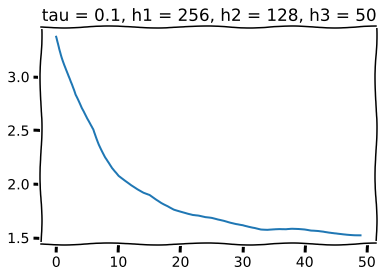

In [37]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                          reduction=tf.keras.losses.Reduction.SUM)
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

resnet_simclr_2 = get_resnet_simclr(256, 128, 50)

epoch_wise_loss, resnet_simclr  = train_simclr(resnet_simclr_2, train_ds, optimizer, criterion,
                 temperature=0.1, epochs=50)

#h1,h2,h3 are number of nodes in hidden layers of projection head
with plt.xkcd():
    plt.plot(epoch_wise_loss)
    plt.title("tau = 0.1, h1 = 256, h2 = 128, h3 = 50")
    plt.show()

## Store the weights to a safe place :)

In [38]:
import datetime
filename = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "resnet_simclr.h5"
print(filename)
resnet_simclr.save_weights(filename)

'20220905-082335resnet_simclr.h5'